# Basic Neural Network

A simple feedforward neural network to classify spin configurations. Based off of course material from CSCI 1051 by Teal Witter.

In [2]:
# We start by importing the libraries we'll use today
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

Load the data generated by the ON_Model

In [3]:
# data transforms
dset_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()])


# Use the image folder function to create datasets
dsets = {x: datasets.ImageFolder(f"../data/binary_class/{x}", dset_transform)
         for x in ['train', 'test']}

# dataloaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=16,
#                                               shuffle=(x == "train"))
#                for x in ['train', 'test']}

trainingdata = dsets['train']
testdata = dsets['test']

#load a dataset to test for performance vs temperature
perfdata = datasets.ImageFolder(f"../data/temp_class/test", dset_transform)


trainDataLoader = torch.utils.data.DataLoader(trainingdata,batch_size=64,shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata,batch_size=64,shuffle=False)
perfDataLoader = torch.utils.data.DataLoader(perfdata,batch_size=64,shuffle=False)

In [4]:
print(len(trainingdata))

440


torch.Size([1, 25, 25])
1


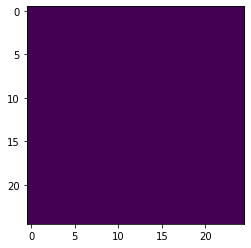

In [5]:
image, label = trainingdata[355]
print(image.shape)
print(label)
plt.imshow(image.squeeze().numpy())
plt.show()

This is a basic feedforward neural net architecture

In [6]:
class NeuralNet(torch.nn.Module):
  def __init__(self):
    super(NeuralNet, self).__init__()
    self.layers = torch.nn.Sequential(
      torch.nn.Linear(25*25, 256),
      torch.nn.ReLU(),
      torch.nn.Linear(256, 128),
      torch.nn.ReLU(),
      torch.nn.Linear(128, 64),
      torch.nn.ReLU(),
      torch.nn.Linear(64, 2)
    )
  
  def forward(self, x):
    x = x.view(-1, 25*25) # change so 784 vector instead of 28x28 matrix
    return self.layers(x)



In [7]:
# define loss function, optimizer
model = NeuralNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
save_loss = {'train':[], 'test':[]}
save_acc = {'train':[], 'test':[]}

Now let's train our model!

In [8]:
train_loss_history = []
test_loss_history = []

for epoch in range(30):
  train_loss = 0.0
  test_loss = 0.0
  for i, data in enumerate(trainDataLoader):
    images, labels = data
    optimizer.zero_grad()
    predicted_output = model(images)
    fit = criterion(predicted_output, labels)
    fit.backward()
    optimizer.step()
    train_loss += fit.item() / len(trainingdata)
  for i, data in enumerate(testDataLoader):
    with torch.no_grad():
      images, labels = data
      predicted_output = model(images)
      fit = criterion(predicted_output, labels)
      test_loss += fit.item() / len(testdata)
  train_loss_history += [train_loss]
  test_loss_history += [test_loss]
  print(f'Epoch {epoch}, Train loss {train_loss}, Test loss {test_loss}')
    

Epoch 0, Train loss 0.011465063149278813, Test loss 0.011250390141618018
Epoch 1, Train loss 0.01140141703865745, Test loss 0.01117092487858791
Epoch 2, Train loss 0.011309785599058323, Test loss 0.011073161807714725
Epoch 3, Train loss 0.01120177683505145, Test loss 0.010975822981666116
Epoch 4, Train loss 0.011098431592637842, Test loss 0.01088160603654151
Epoch 5, Train loss 0.011000873690301722, Test loss 0.01079302102911706
Epoch 6, Train loss 0.010900389877232637, Test loss 0.01071387669619392
Epoch 7, Train loss 0.01082005270502784, Test loss 0.010637933015823366
Epoch 8, Train loss 0.010739584267139434, Test loss 0.010567875118816598
Epoch 9, Train loss 0.010665491358800367, Test loss 0.010501061818178961
Epoch 10, Train loss 0.010591866753318094, Test loss 0.01044042437684302
Epoch 11, Train loss 0.010535056618126957, Test loss 0.010383580595839256
Epoch 12, Train loss 0.010469559376890009, Test loss 0.010332598873213226
Epoch 13, Train loss 0.010421614619818602, Test loss 0.0

Let's plot our loss by epoch to see how we did.

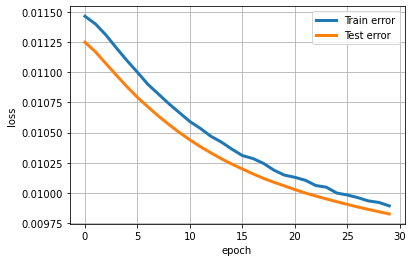

In [9]:
plt.plot(range(30),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(30),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.show()

/tmp/ipykernel_2220067/2300132830.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_output = torch.nn.functional.softmax(predicted_output).detach().numpy()


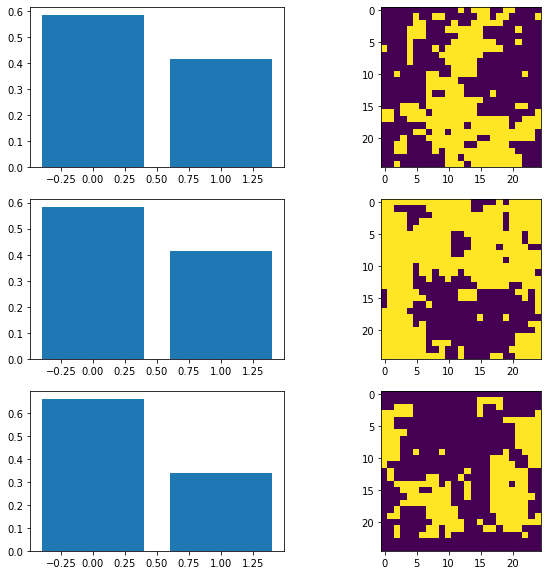

In [10]:
plt.figure(figsize=(10,10))
for index in [0,1,2]:
  
  image, label = trainingdata[index]
  # print(image)
  predicted_output = model(images)[index]
  # Need to apply softmax to get probabilities
  prob_output = torch.nn.functional.softmax(predicted_output).detach().numpy()

  plt.subplot(3,2,2*(index)+1)
  plt.bar(list(range(len(prob_output))), prob_output)
 
  plt.subplot(3,2,2*(index)+2)
  plt.imshow(image.squeeze().numpy())
  
plt.show()

Now lets use the dataset that we classified by temperature to plot confidence vs temperature

In [14]:
temp_pred_below = []
temp_pred_above = []
for idx in range(len(perfdata)):
  image, label = perfdata[idx]
  predicted_output = model(image.unsqueeze(0))
  
  # Need to apply softmax to get probabilities
  prob_output = torch.nn.functional.softmax(predicted_output).detach().numpy()
  predicted_label = torch.argmax(predicted_output).item()
  print(f"predicted label: {predicted_label}, actual label: {label}")

  #get temp from label
  temp = perfdata.classes[label]
  temp_pred_below.append([float(temp), prob_output[0][0]])
  temp_pred_above.append([float(temp), prob_output[0][1]])

#plot the data
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter([x[0] for x in temp_pred_below], [x[1] for x in temp_pred_below], c='b', marker="s", label='confidence below critical temp')
ax.scatter([x[0] for x in temp_pred_above], [x[1] for x in temp_pred_above], c='r', marker="o", label='confidence above critical temp')

plt.legend(loc='upper left');
plt.show()




tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0.

/tmp/ipykernel_2150766/1255016455.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_output = torch.nn.functional.softmax(predicted_output).detach().numpy()


[[0.6773725  0.32262757]]
[[0.6766621  0.32333785]]
[[0.6749213 0.3250787]]
[[0.6742448 0.3257552]]
[[0.6398361  0.36016396]]
[[0.6661946  0.33380538]]
[[0.6709513 0.3290487]]
[[0.6688903 0.3311097]]
[[0.67492193 0.3250781 ]]
[[0.6767516  0.32324848]]
[[0.66296303 0.3370369 ]]
[[0.668121   0.33187893]]
[[0.6790052  0.32099476]]
[[0.67065054 0.32934955]]
[[0.65951496 0.34048507]]
[[0.65232456 0.3476754 ]]
[[0.6341029  0.36589715]]
[[0.6686283  0.33137178]]
[[0.68056494 0.31943506]]
[[0.64629453 0.35370556]]
[[0.6755162  0.32448378]]
[[0.6686426 0.3313574]]
[[0.6726292  0.32737082]]
[[0.6634295 0.3365705]]
[[0.6792582 0.3207418]]
[[0.64578784 0.35421214]]
[[0.6871158 0.3128842]]
[[0.6345837  0.36541623]]
[[0.6489746  0.35102537]]
[[0.672815   0.32718492]]
[[0.6439776  0.35602245]]
[[0.681101   0.31889892]]
[[0.6726614  0.32733858]]
[[0.6286579  0.37134215]]
[[0.6814584 0.3185416]]
[[0.67358726 0.32641268]]
[[0.659144 0.340856]]
[[0.66303    0.33697003]]
[[0.6783562 0.3216438]]
[[0.686663

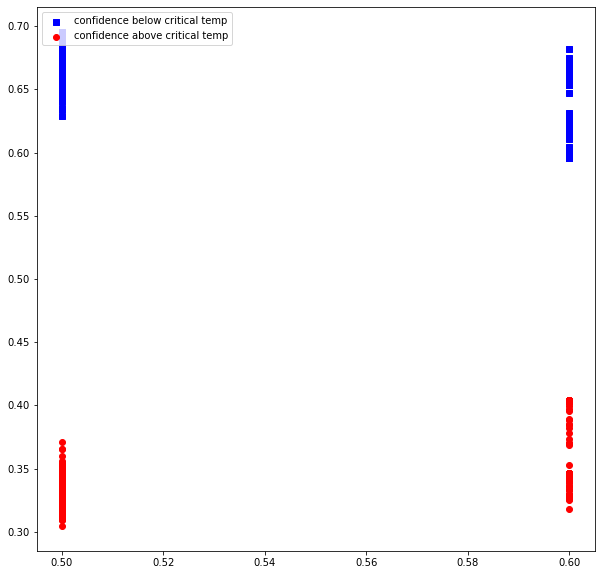

In [ ]:
temp_pred_below = []
temp_pred_above = []
for idx in range(len(perfdata)):
  image, label = trainingdata[idx]
  predicted_output = model(image.unsqueeze(0))
  
  # Need to apply softmax to get probabilities
  prob_output = torch.nn.functional.softmax(predicted_output).detach().numpy()
  # print(prob_output)
  #get temp from label
  temp = perfdata.classes[label]

  temp_pred_below.append([float(temp), prob_output[0][0]])
  temp_pred_above.append([float(temp), prob_output[0][1]])

#plot the data
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter([x[0] for x in temp_pred_below], [x[1] for x in temp_pred_below], c='b', marker="s", label='confidence below critical temp')
ax.scatter([x[0] for x in temp_pred_above], [x[1] for x in temp_pred_above], c='r', marker="o", label='confidence above critical temp')

plt.legend(loc='upper left');
plt.show()